In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import seaborn as sns
sns.despine()

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import merge
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers

import theano
theano.config.compute_test_value = "ignore"
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv('ts.csv')
data.head()

,DATE,IN_FOR,OUT_FOR,IN_KZT,OUT_KZT
0,1/1/2016,0.0,122953.0,1899647.0,1584705.0
1,1/2/2016,2942.0,115059.0,2706416.0,2315761.0
2,1/3/2016,263.0,147905.0,3548855.0,2971268.0
3,1/4/2016,13533594.0,9363025.0,23528654.0,11716898.0
4,1/5/2016,36769881.0,32769452.0,37289979.0,22565273.0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 5 columns):
DATE       731 non-null object
IN_FOR     731 non-null float64
OUT_FOR    731 non-null float64
IN_KZT     731 non-null float64
OUT_KZT    731 non-null float64
dtypes: float64(4), object(1)
memory usage: 28.6+ KB


In [4]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b
 
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


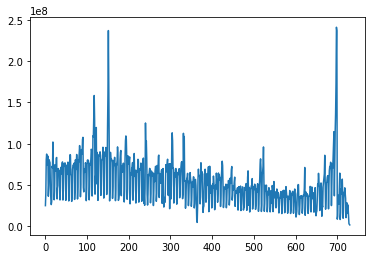

list index out of range


In [5]:
data0 = data[::-1]
data1 = data0.ix[:, 'OUT_KZT'].tolist()

# Uncomment below to use price change time series
# data1 = data0.ix[:, 'IN_FOR'].pct_change().dropna().tolist()

plt.plot(data1)
plt.show()

WINDOW = 30
EMB_SIZE = 1
STEP = 1
FORECAST = 5

# Straightforward way for creating time windows
X, Y = [], []
for i in range(0, len(data1), STEP): 
    try:
        x_i = data1[i:i+WINDOW]
        y_i = data1[i+WINDOW+FORECAST]  

        last_close = x_i[WINDOW-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

    except Exception as e:
        print(e)
        break

    X.append(x_i)
    Y.append(y_i)

X = [(np.array(x) - np.mean(x)) / np.std(x) for x in X] # comment it to remove normalization
X, Y = np.array(X), np.array(Y)

X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [6]:
model = Sequential()
model.add(Dense(64, input_dim=30,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dropout(0.35))
model.add(Dense(16,
                activity_regularizer=regularizers.l2(0.01)))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dense(2))
model.add(Activation('linear'))

opt = Nadam(lr=0.001)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="out_kzt.hdf5", verbose=1, save_best_only=True)
model.compile(optimizer=opt, 
              loss='mean_squared_error',
              metrics=['acc'])

In [7]:
history = model.fit(X_train, Y_train, 
          nb_epoch = 90, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Train on 626 samples, validate on 70 samples
Epoch 1/90
626/626 [==============================] - 1s 2ms/step - loss: 79.2218 - acc: 0.5112 - val_loss: 37.0562 - val_acc: 0.4714

Epoch 00001: val_loss improved from inf to 37.05624, saving model to out_kzt.hdf5
Epoch 2/90
626/626 [==============================] - 0s 34us/step - loss: 72.9807 - acc: 0.5144 - val_loss: 34.7395 - val_acc: 0.4571

Epoch 00002: val_loss improved from 37.05624 to 34.73948, saving model to out_kzt.hdf5
Epoch 3/90
626/626 [==============================] - 0s 56us/step - loss: 66.8710 - acc: 0.5208 - val_loss: 32.4888 - val_acc: 0.4571

Epoch 00003: val_loss improved from 34.73948 to 32.48877, saving model to out_kzt.hdf5
Epoch 4/90
626/626 [==============================] - 0s 59us/step - loss: 62.1879 - acc: 0.5559 - val_loss: 30.3338 - val_acc: 0.4714

Epoch 00004: val_loss improved from 32.48877 to 30.33383, saving model to out_kzt.hdf5
Epoch 5/90
626/626 [==============================] - 0s 44us/step - 


Epoch 00037: val_loss improved from 6.68009 to 6.43346, saving model to out_kzt.hdf5
Epoch 38/90
626/626 [==============================] - 0s 36us/step - loss: 10.0819 - acc: 0.6022 - val_loss: 6.1919 - val_acc: 0.5000

Epoch 00038: val_loss improved from 6.43346 to 6.19195, saving model to out_kzt.hdf5
Epoch 39/90
626/626 [==============================] - 0s 30us/step - loss: 9.7641 - acc: 0.6198 - val_loss: 5.9614 - val_acc: 0.5000

Epoch 00039: val_loss improved from 6.19195 to 5.96143, saving model to out_kzt.hdf5
Epoch 40/90
626/626 [==============================] - 0s 27us/step - loss: 9.4264 - acc: 0.6102 - val_loss: 5.7424 - val_acc: 0.5143

Epoch 00040: val_loss improved from 5.96143 to 5.74235, saving model to out_kzt.hdf5
Epoch 41/90
626/626 [==============================] - 0s 30us/step - loss: 9.0457 - acc: 0.6613 - val_loss: 5.5316 - val_acc: 0.5286

Epoch 00041: val_loss improved from 5.74235 to 5.53162, saving model to out_kzt.hdf5
Epoch 42/90
626/626 [============

Epoch 75/90
626/626 [==============================] - 0s 27us/step - loss: 3.0908 - acc: 0.6917 - val_loss: 1.8301 - val_acc: 0.6143

Epoch 00075: val_loss improved from 1.88204 to 1.83006, saving model to out_kzt.hdf5
Epoch 76/90
626/626 [==============================] - 0s 26us/step - loss: 3.0372 - acc: 0.7284 - val_loss: 1.7813 - val_acc: 0.6143

Epoch 00076: val_loss improved from 1.83006 to 1.78131, saving model to out_kzt.hdf5
Epoch 77/90
626/626 [==============================] - 0s 25us/step - loss: 2.9247 - acc: 0.7093 - val_loss: 1.7337 - val_acc: 0.6143

Epoch 00077: val_loss improved from 1.78131 to 1.73370, saving model to out_kzt.hdf5
Epoch 78/90
626/626 [==============================] - 0s 25us/step - loss: 2.8784 - acc: 0.7125 - val_loss: 1.6887 - val_acc: 0.6143

Epoch 00078: val_loss improved from 1.73370 to 1.68871, saving model to out_kzt.hdf5
Epoch 79/90
626/626 [==============================] - 0s 26us/step - loss: 2.7958 - acc: 0.7013 - val_loss: 1.6445 - va

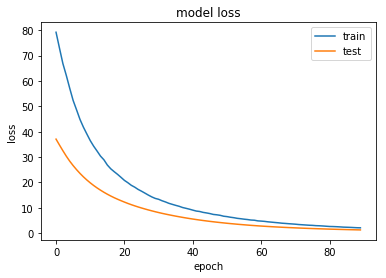

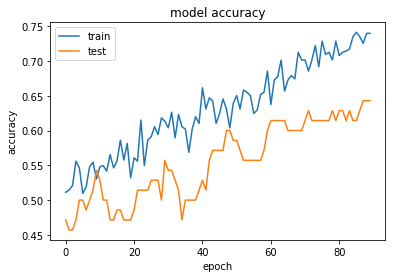

In [8]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

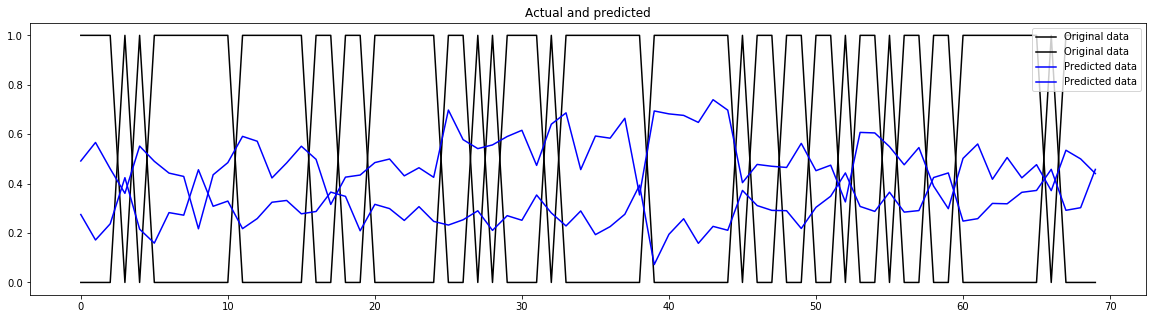

In [9]:
pred = model.predict(np.array(X_test)) 
original = Y_test 
predicted = pred  
plt.figure(figsize=(20, 5))
plt.plot(original, color='black', label = 'Original data') 
plt.plot(predicted, color='blue', label = 'Predicted data') 
plt.legend(loc='best') 
plt.title('Actual and predicted') 
plt.show()